In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-exam-score-dataset-analysis/student_exam_scores.csv


# Import necessary libraries

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_curve, auc, precision_recall_curve, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
df=pd.read_csv('/kaggle/input/student-exam-score-dataset-analysis/student_exam_scores.csv')
df.head()

,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3


# Basic dataset information

In [4]:

print("="*50)
print("DATASET INFORMATION")
print("="*50)
print(df.info())
print("\n" + "="*50)
print("DESCRIPTIVE STATISTICS")
print("="*50)
print(df.describe())

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB
None

DESCRIPTIVE STATISTICS
       hours_studied  sleep_hours  attendance_percent  previous_scores  \
count     200.000000   200.000000          200.000000       200.000000   
mean        6.325500     6.622000           74.830000        66.800000   
std         3.227317     1.497138           14.249905        15.663869   
min         1.000000     4.000000           50.300000        40.000000   
25%         3.500000   

# Data Quality Check

In [5]:

print("="*50)
print("DATA QUALITY CHECK")
print("="*50)
print("Missing values:")
print(df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())
print("\nData types:")
print(df.dtypes)

DATA QUALITY CHECK
Missing values:
student_id            0
hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64

Duplicate rows: 0

Data types:
student_id             object
hours_studied         float64
sleep_hours           float64
attendance_percent    float64
previous_scores         int64
exam_score            float64
dtype: object


# Add pass/fail status (assuming passing score is 30)

In [6]:
# Add pass/fail status (assuming passing score is 30)
passing_score = 30
df['status'] = df['exam_score'].apply(lambda x: 'Pass' if x >= passing_score else 'Fail')

print("="*50)
print("DATASET WITH PASS/FAIL STATUS")
print("="*50)
print(df)

# Calculate pass rate
pass_rate = (df['status'] == 'Pass').mean() * 100
print(f"\nOverall Pass Rate: {pass_rate:.1f}%")

DATASET WITH PASS/FAIL STATUS
    student_id  hours_studied  sleep_hours  attendance_percent  \
0         S001            8.0          8.8                72.1   
1         S002            1.3          8.6                60.7   
2         S003            4.0          8.2                73.7   
3         S004            3.5          4.8                95.1   
4         S005            9.1          6.4                89.8   
..         ...            ...          ...                 ...   
195       S196           10.5          5.4                94.0   
196       S197            7.1          6.1                85.1   
197       S198            1.6          6.9                63.8   
198       S199           12.0          7.3                50.5   
199       S200           10.2          6.3                97.4   

     previous_scores  exam_score status  
0                 45        30.2   Pass  
1                 55        25.0   Fail  
2                 86        35.8   Pass  
3        

#  Univariate Analysis

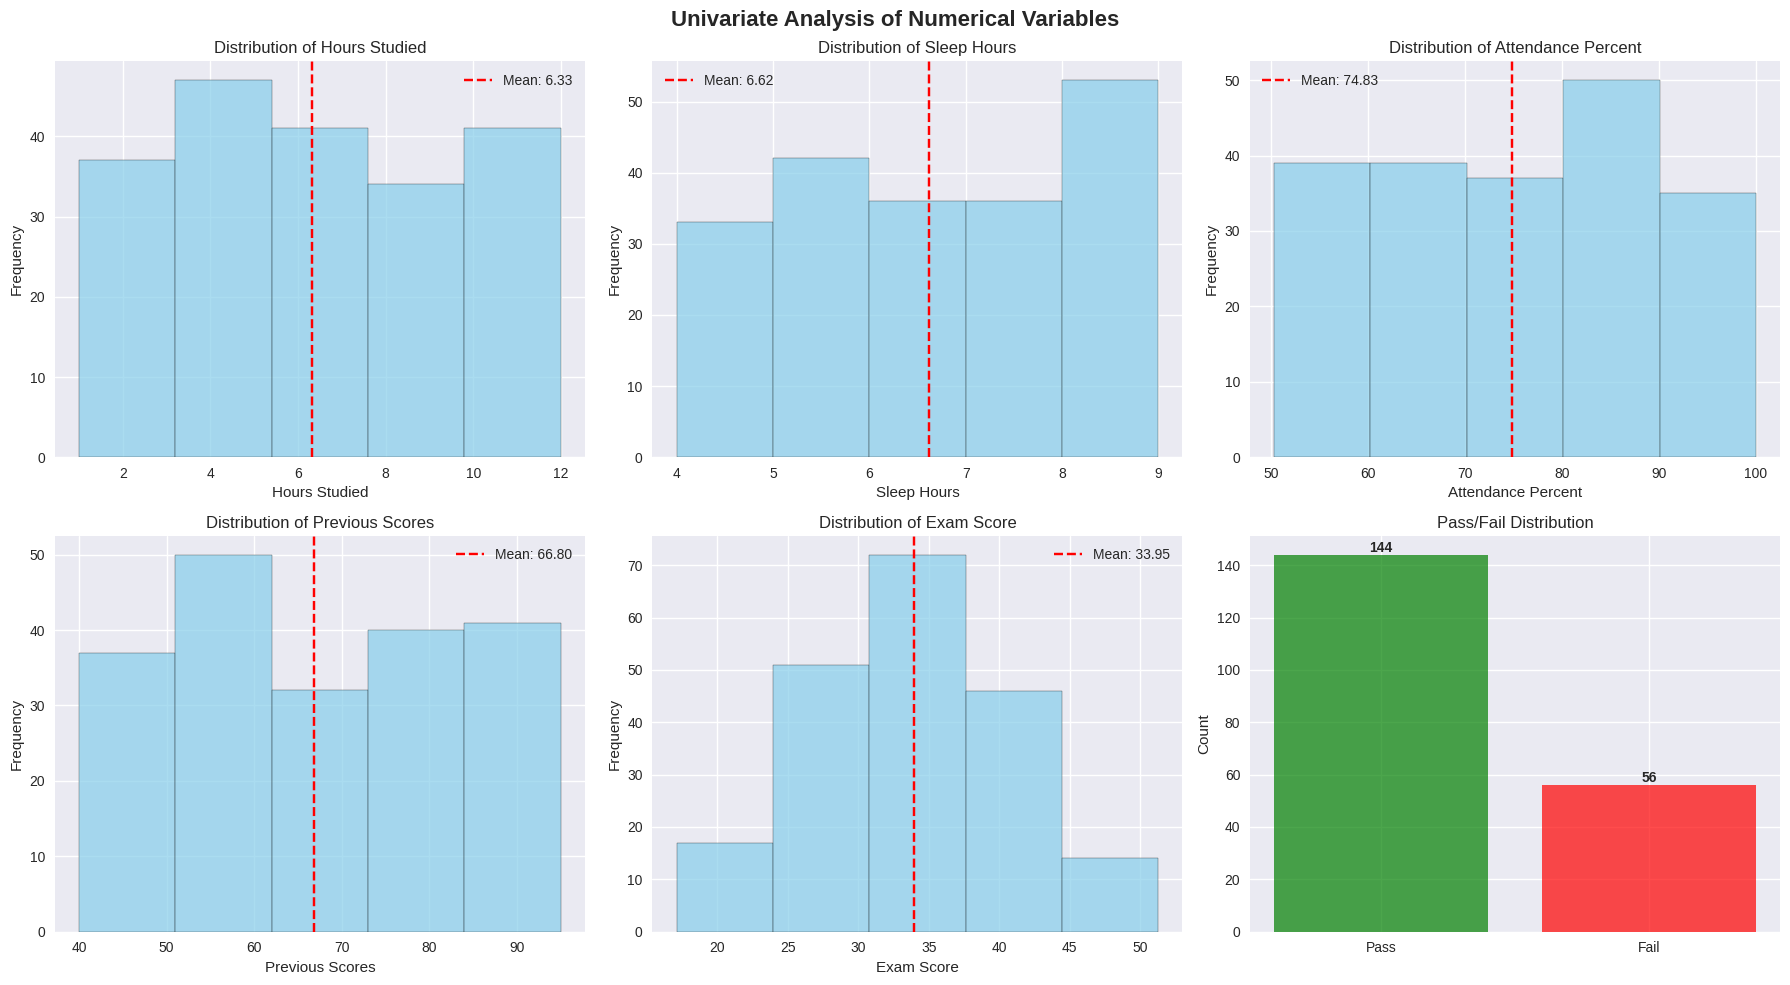

In [7]:
# Create subplots for univariate analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Univariate Analysis of Numerical Variables', fontsize=16, fontweight='bold')

# List of numerical columns (excluding student_id)
numerical_cols = ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores', 'exam_score']

for i, col in enumerate(numerical_cols):
    row = i // 3
    col_pos = i % 3
    
    # Histogram with KDE
    axes[row, col_pos].hist(df[col], bins=5, alpha=0.7, color='skyblue', edgecolor='black')
    axes[row, col_pos].set_title(f'Distribution of {col.replace("_", " ").title()}')
    axes[row, col_pos].set_xlabel(col.replace('_', ' ').title())
    axes[row, col_pos].set_ylabel('Frequency')
    
    # Add mean line
    mean_val = df[col].mean()
    axes[row, col_pos].axvline(mean_val, color='red', linestyle='--', 
                              label=f'Mean: {mean_val:.2f}')
    axes[row, col_pos].legend()

# Status distribution
status_counts = df['status'].value_counts()
axes[1, 2].bar(status_counts.index, status_counts.values, color=['green', 'red'], alpha=0.7)
axes[1, 2].set_title('Pass/Fail Distribution')
axes[1, 2].set_ylabel('Count')
for i, v in enumerate(status_counts.values):
    axes[1, 2].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Bivariate Analysis

CORRELATION MATRIX
                    hours_studied  sleep_hours  attendance_percent  \
hours_studied            1.000000     0.077864           -0.031311   
sleep_hours              0.077864     1.000000            0.000572   
attendance_percent      -0.031311     0.000572            1.000000   
previous_scores          0.069078    -0.194251            0.051958   
exam_score               0.776751     0.188222            0.225713   

                    previous_scores  exam_score  
hours_studied              0.069078    0.776751  
sleep_hours               -0.194251    0.188222  
attendance_percent         0.051958    0.225713  
previous_scores            1.000000    0.431105  
exam_score                 0.431105    1.000000  


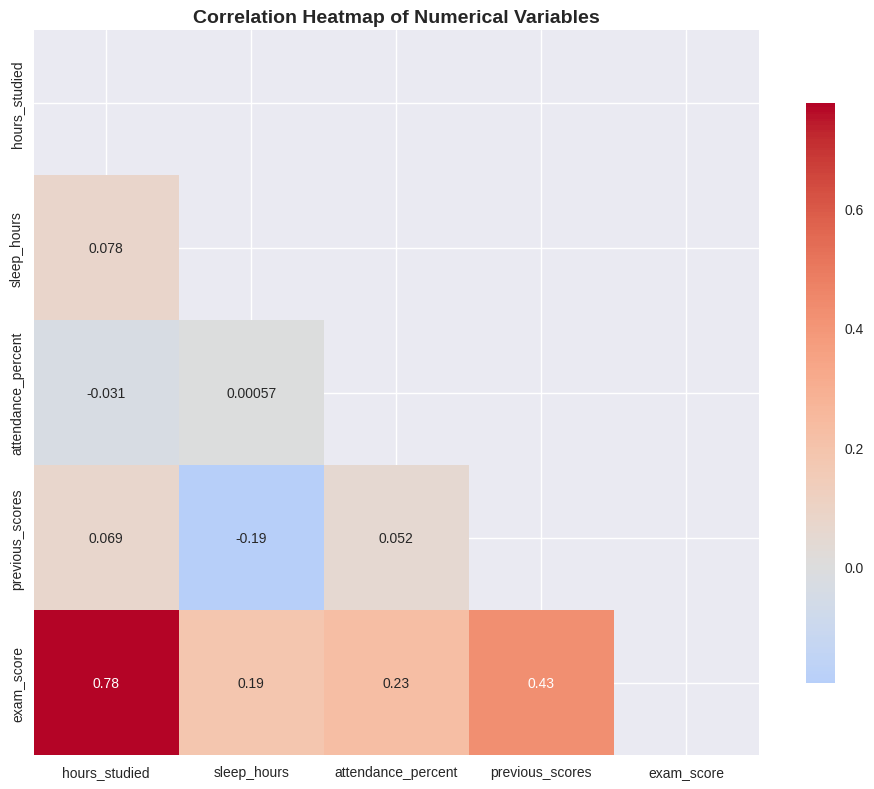

In [8]:
# Correlation Analysis
print("="*50)
print("CORRELATION MATRIX")
print("="*50)
correlation_matrix = df[numerical_cols].corr()
print(correlation_matrix)

# Correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, mask=mask, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

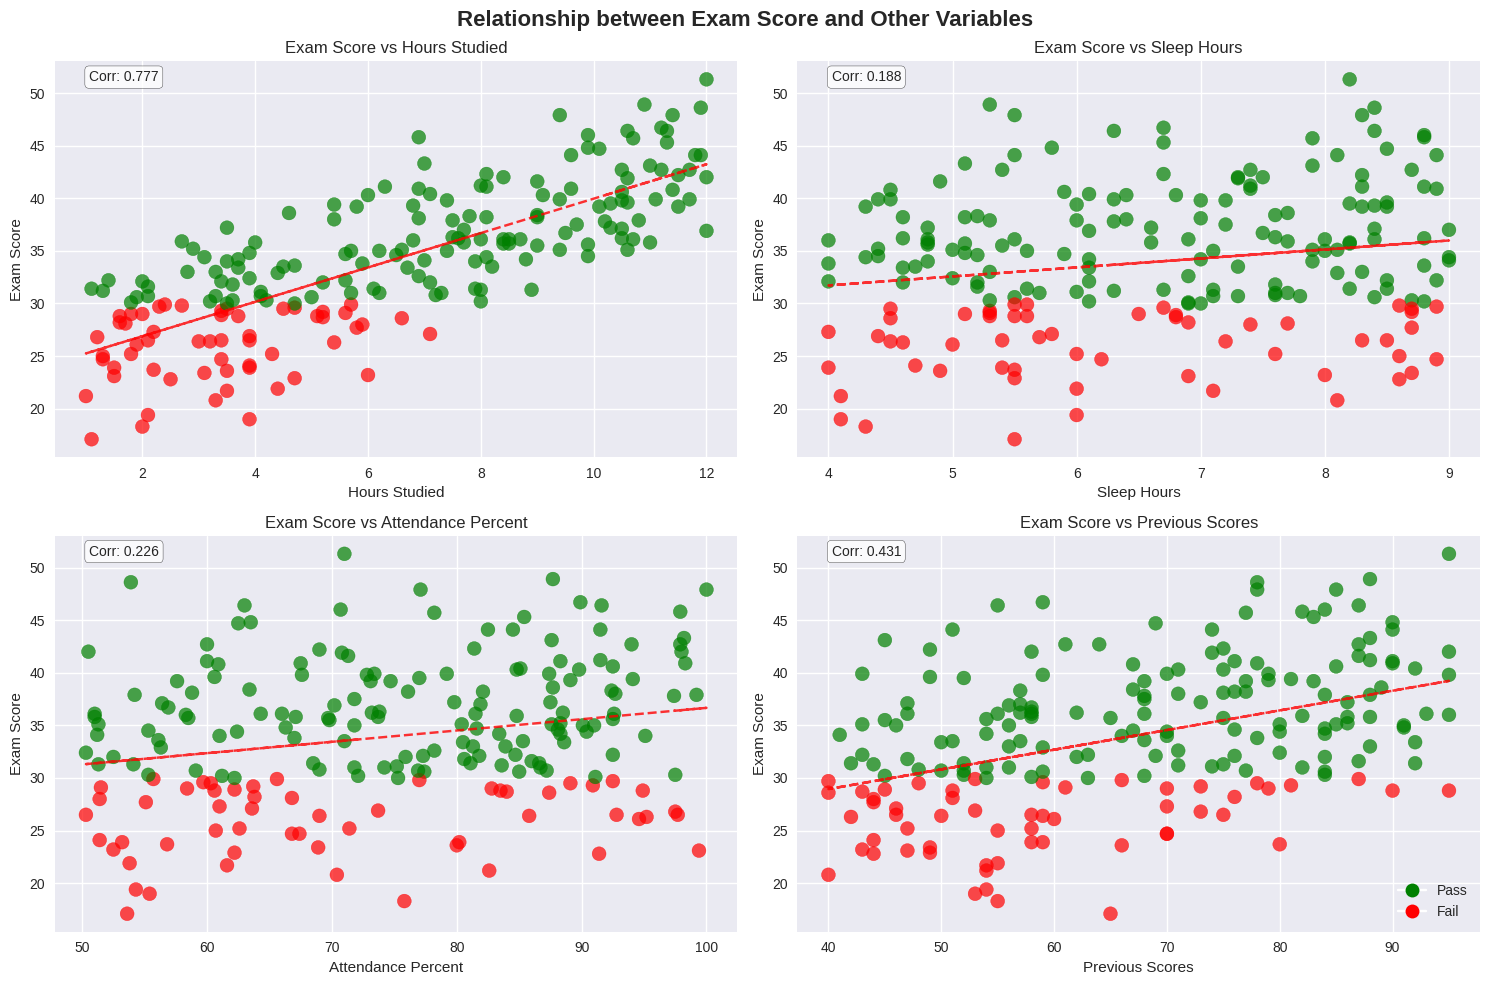

In [9]:
# Scatter plots to examine relationships with exam score
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Relationship between Exam Score and Other Variables', fontsize=16, fontweight='bold')

predictors = ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']

for i, predictor in enumerate(predictors):
    row = i // 2
    col = i % 2
    
    # Color by pass/fail status
    colors = ['red' if status == 'Fail' else 'green' for status in df['status']]
    
    axes[row, col].scatter(df[predictor], df['exam_score'], c=colors, alpha=0.7, s=100)
    axes[row, col].set_xlabel(predictor.replace('_', ' ').title())
    axes[row, col].set_ylabel('Exam Score')
    axes[row, col].set_title(f'Exam Score vs {predictor.replace("_", " ").title()}')
    
    # Add regression line
    z = np.polyfit(df[predictor], df['exam_score'], 1)
    p = np.poly1d(z)
    axes[row, col].plot(df[predictor], p(df[predictor]), "r--", alpha=0.8)
    
    # Add correlation coefficient
    corr = df[predictor].corr(df['exam_score'])
    axes[row, col].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                       transform=axes[row, col].transAxes, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                         markersize=10, label='Pass'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                         markersize=10, label='Fail')]
axes[1, 1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Advanced Multivariate Analysis

<Figure size 1200x1000 with 0 Axes>

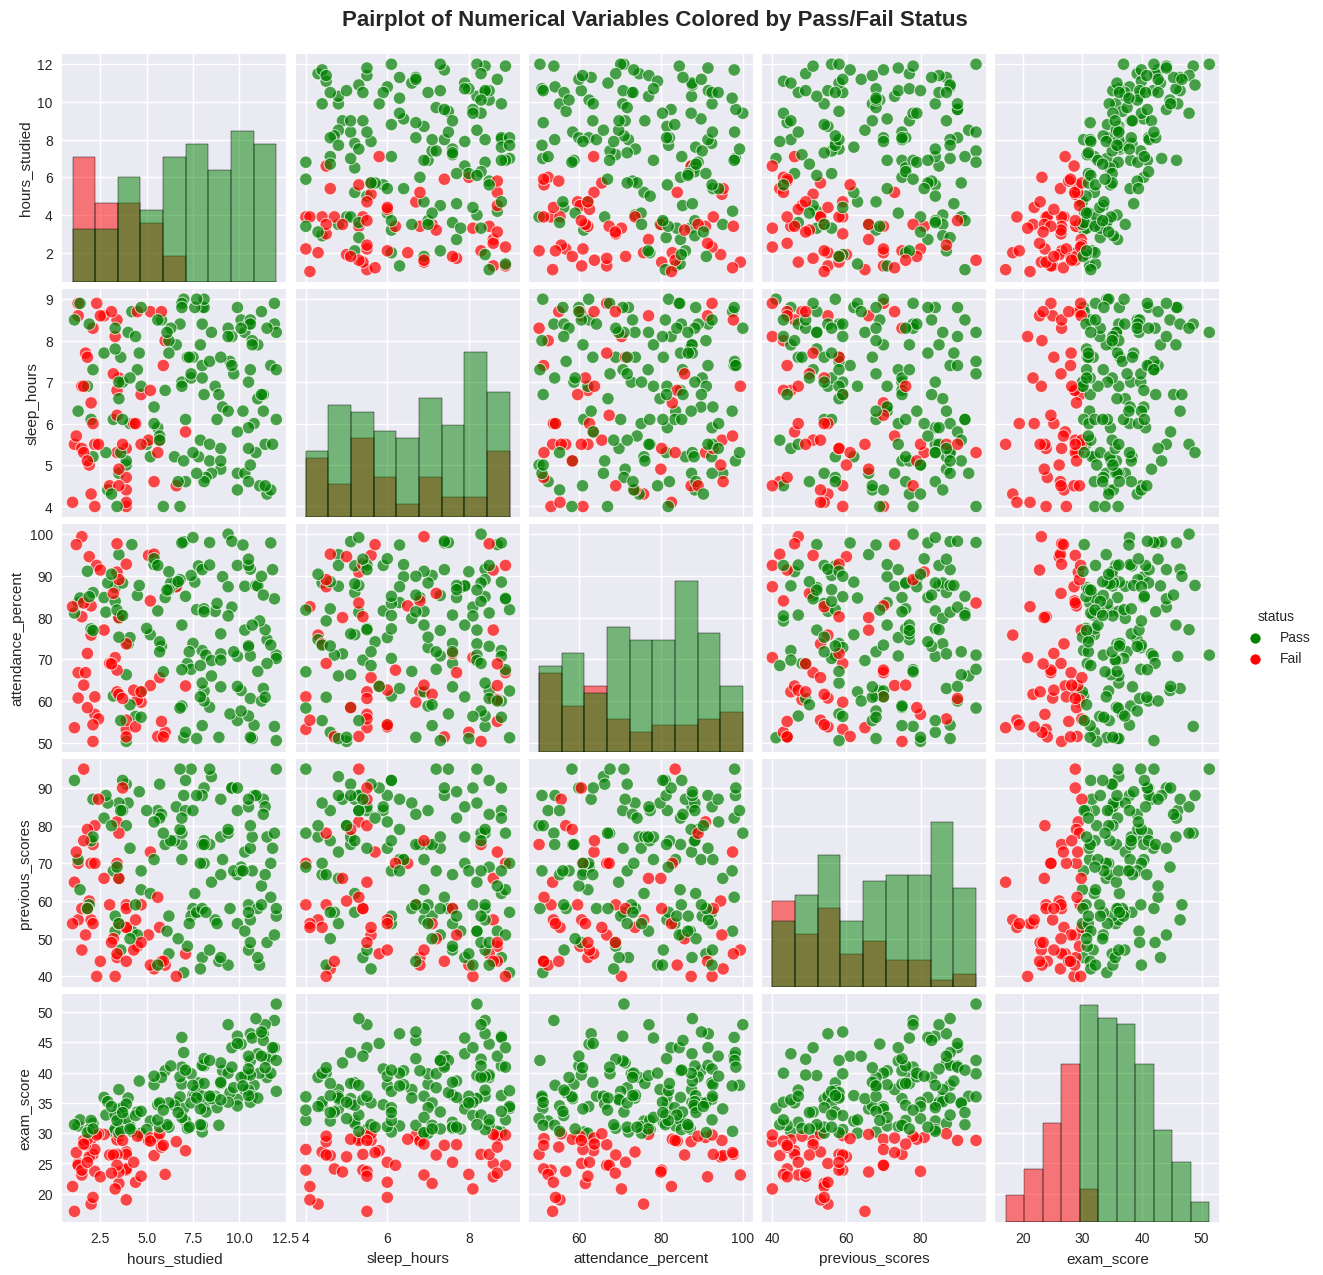

In [10]:
# Pairplot with hue as status
plt.figure(figsize=(12, 10))
sns.pairplot(df, vars=numerical_cols, hue='status', 
             palette={'Pass': 'green', 'Fail': 'red'},
             diag_kind='hist', plot_kws={'alpha': 0.7, 's': 80})
plt.suptitle('Pairplot of Numerical Variables Colored by Pass/Fail Status', 
             y=1.02, fontsize=16, fontweight='bold')
plt.show()

#  Statistical Testing

In [11]:
from scipy import stats

print("="*50)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Compare means between pass and fail groups
for col in numerical_cols:
    pass_scores = df[df['status'] == 'Pass'][col]
    fail_scores = df[df['status'] == 'Fail'][col]
    
    # T-test for significant differences
    t_stat, p_value = stats.ttest_ind(pass_scores, fail_scores)
    
    print(f"\n{col.replace('_', ' ').title()}:")
    print(f"  Pass group mean: {pass_scores.mean():.2f}")
    print(f"  Fail group mean: {fail_scores.mean():.2f}")
    print(f"  T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")
    print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

STATISTICAL SIGNIFICANCE TESTING

Hours Studied:
  Pass group mean: 7.48
  Fail group mean: 3.36
  T-statistic: 9.898, P-value: 0.000
  Significant difference: Yes

Sleep Hours:
  Pass group mean: 6.75
  Fail group mean: 6.30
  T-statistic: 1.920, P-value: 0.056
  Significant difference: No

Attendance Percent:
  Pass group mean: 76.36
  Fail group mean: 70.90
  T-statistic: 2.462, P-value: 0.015
  Significant difference: Yes

Previous Scores:
  Pass group mean: 70.03
  Fail group mean: 58.48
  T-statistic: 4.952, P-value: 0.000
  Significant difference: Yes

Exam Score:
  Pass group mean: 37.09
  Fail group mean: 25.89
  T-statistic: 15.614, P-value: 0.000
  Significant difference: Yes


# Feature Importance Analysis

FEATURE IMPORTANCE (Correlation with Exam Score)
              feature  correlation_with_exam  abs_correlation
0       hours_studied               0.776751         0.776751
3     previous_scores               0.431105         0.431105
2  attendance_percent               0.225713         0.225713
1         sleep_hours               0.188222         0.188222


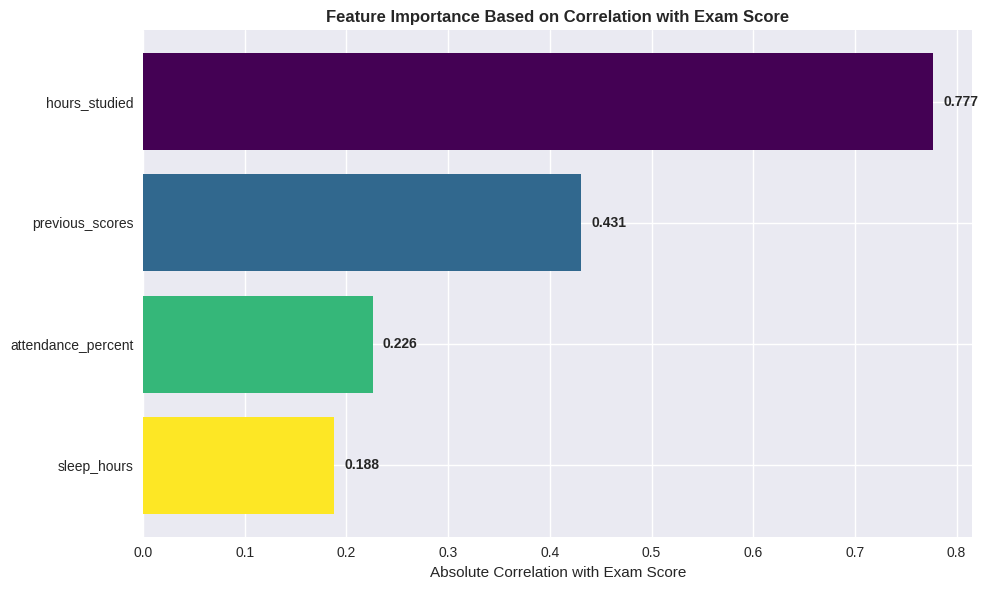

In [12]:
# Calculate feature importance using correlation with exam score
feature_importance = pd.DataFrame({
    'feature': numerical_cols[:-1],  # exclude exam_score itself
    'correlation_with_exam': [df[col].corr(df['exam_score']) for col in numerical_cols[:-1]],
    'abs_correlation': [abs(df[col].corr(df['exam_score'])) for col in numerical_cols[:-1]]
})

feature_importance = feature_importance.sort_values('abs_correlation', ascending=False)

print("="*50)
print("FEATURE IMPORTANCE (Correlation with Exam Score)")
print("="*50)
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance['feature'], 
                feature_importance['abs_correlation'],
                color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))

plt.xlabel('Absolute Correlation with Exam Score')
plt.title('Feature Importance Based on Correlation with Exam Score', fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels on bars
for bar, corr in zip(bars, feature_importance['correlation_with_exam']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{corr:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Outlier Detection

In [13]:
# Detect outliers using IQR method
print("="*50)
print("OUTLIER DETECTION")
print("="*50)

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\n{col.replace('_', ' ').title()}:")
    print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"  Number of outliers: {len(outliers)}")
    if len(outliers) > 0:
        print(f"  Outlier values: {list(outliers[col])}")

OUTLIER DETECTION

Hours Studied:
  Lower bound: -4.75, Upper bound: 17.25
  Number of outliers: 0

Sleep Hours:
  Lower bound: 1.21, Upper bound: 12.11
  Number of outliers: 0

Attendance Percent:
  Lower bound: 24.36, Upper bound: 125.26
  Number of outliers: 0

Previous Scores:
  Lower bound: 15.00, Upper bound: 119.00
  Number of outliers: 0

Exam Score:
  Lower bound: 15.62, Upper bound: 52.62
  Number of outliers: 0


# Apply Machine Learning Techniques

In [14]:
# Prepare features and target
X = df[['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']]
y = df['status']


In [15]:
# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 0: Fail, 1: Pass

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, 
                                                    random_state=42, stratify=y_encoded)

In [17]:

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dataset shape:", X.shape)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Class distribution - Train:", np.unique(y_train, return_counts=True))
print("Class distribution - Test:", np.unique(y_test, return_counts=True))

Dataset shape: (200, 4)
Training set size: (140, 4)
Test set size: (60, 4)
Class distribution - Train: (array([0, 1]), array([ 39, 101]))
Class distribution - Test: (array([0, 1]), array([17, 43]))


In [18]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

In [19]:
# Train and evaluate models
results = {}
predictions = {}
probabilities = {}

for name, model in models.items():
    # Use scaled data for models that benefit from scaling
    if name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test
    
    # Train model
    model.fit(X_tr, y_train)
      # Make predictions
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else np.zeros(len(y_test))
     # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_tr, y_train, cv=3, scoring='accuracy')
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    predictions[name] = y_pred
    probabilities[name] = y_prob
    
    print(f"{name:20} | Accuracy: {accuracy:.3f} | CV Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Logistic Regression  | Accuracy: 0.883 | CV Score: 0.850 ± 0.070
Decision Tree        | Accuracy: 0.817 | CV Score: 0.743 ± 0.075
Random Forest        | Accuracy: 0.767 | CV Score: 0.822 ± 0.072
Gradient Boosting    | Accuracy: 0.817 | CV Score: 0.786 ± 0.051
SVM                  | Accuracy: 0.867 | CV Score: 0.836 ± 0.070
K-Nearest Neighbors  | Accuracy: 0.833 | CV Score: 0.836 ± 0.065
Naive Bayes          | Accuracy: 0.850 | CV Score: 0.808 ± 0.090


#  Model Performance Comparison Visualization

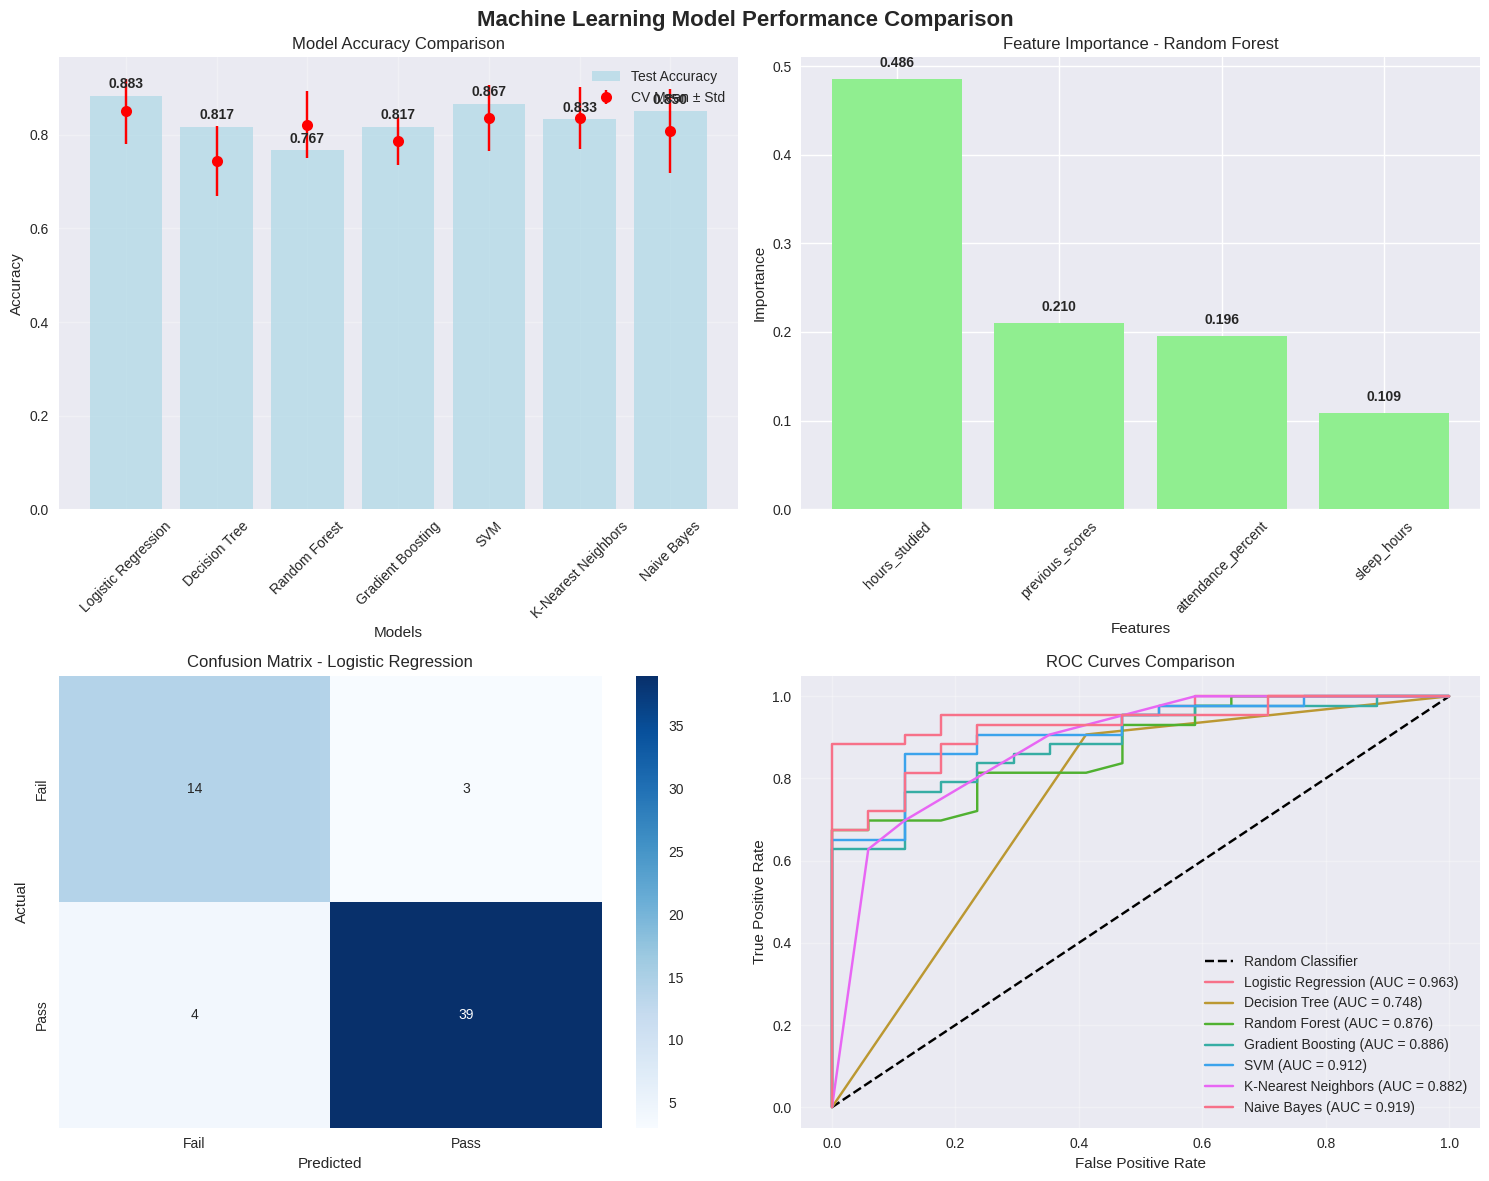

In [20]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Machine Learning Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. Accuracy Comparison
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
cv_means = [results[name]['cv_mean'] for name in model_names]
cv_stds = [results[name]['cv_std'] for name in model_names]

x_pos = np.arange(len(model_names))
axes[0, 0].bar(x_pos, accuracies, color='lightblue', alpha=0.7, label='Test Accuracy')
axes[0, 0].errorbar(x_pos, cv_means, yerr=cv_stds, fmt='o', color='red', 
                   label='CV Mean ± Std', markersize=8)
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(model_names, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Feature Importance (for tree-based models)
feature_names = X.columns
axes[0, 1].set_title('Feature Importance - Random Forest')
rf_model = results['Random Forest']['model']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

bars = axes[0, 1].bar(range(len(importances)), importances[indices], color='lightgreen')
axes[0, 1].set_xlabel('Features')
axes[0, 1].set_ylabel('Importance')
axes[0, 1].set_xticks(range(len(importances)))
axes[0, 1].set_xticklabels([feature_names[i] for i in indices], rotation=45)

# Add value labels on bars
for bar, importance in zip(bars, importances[indices]):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{importance:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Confusion Matrix for Best Model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_predictions = predictions[best_model_name]

cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
axes[1, 0].set_title(f'Confusion Matrix - {best_model_name}')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 4. ROC Curve
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
for name in models.keys():
    if name in probabilities and len(np.unique(probabilities[name])) > 1:
        fpr, tpr, _ = roc_curve(y_test, probabilities[name])
        roc_auc = auc(fpr, tpr)
        axes[1, 1].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

axes[1, 1].set_title('ROC Curves Comparison')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed Model Analysis

In [21]:
# Detailed performance metrics for each model
print("="*70)
print("DETAILED MODEL PERFORMANCE METRICS")
print("="*70)

for name in models.keys():
    print(f"\n{name}:")
    print("-" * len(name))
    y_pred = predictions[name]
    
    # Classification report
    report = classification_report(y_test, y_pred, target_names=['Fail', 'Pass'], output_dict=True)
    print(f"Accuracy: {results[name]['accuracy']:.3f}")
    print(f"Precision: {report['Pass']['precision']:.3f}")
    print(f"Recall: {report['Pass']['recall']:.3f}")
    print(f"F1-Score: {report['Pass']['f1-score']:.3f}")
    
    if name in probabilities and len(np.unique(probabilities[name])) > 1:
        roc_auc = roc_auc_score(y_test, probabilities[name])
        print(f"ROC AUC: {roc_auc:.3f}")

DETAILED MODEL PERFORMANCE METRICS

Logistic Regression:
-------------------
Accuracy: 0.883
Precision: 0.929
Recall: 0.907
F1-Score: 0.918
ROC AUC: 0.963

Decision Tree:
-------------
Accuracy: 0.817
Precision: 0.848
Recall: 0.907
F1-Score: 0.876
ROC AUC: 0.748

Random Forest:
-------------
Accuracy: 0.767
Precision: 0.822
Recall: 0.860
F1-Score: 0.841
ROC AUC: 0.876

Gradient Boosting:
-----------------
Accuracy: 0.817
Precision: 0.864
Recall: 0.884
F1-Score: 0.874
ROC AUC: 0.886

SVM:
---
Accuracy: 0.867
Precision: 0.907
Recall: 0.907
F1-Score: 0.907
ROC AUC: 0.912

K-Nearest Neighbors:
-------------------
Accuracy: 0.833
Precision: 0.867
Recall: 0.907
F1-Score: 0.886
ROC AUC: 0.882

Naive Bayes:
-----------
Accuracy: 0.850
Precision: 0.925
Recall: 0.860
F1-Score: 0.892
ROC AUC: 0.919


#  Decision Boundary Visualization

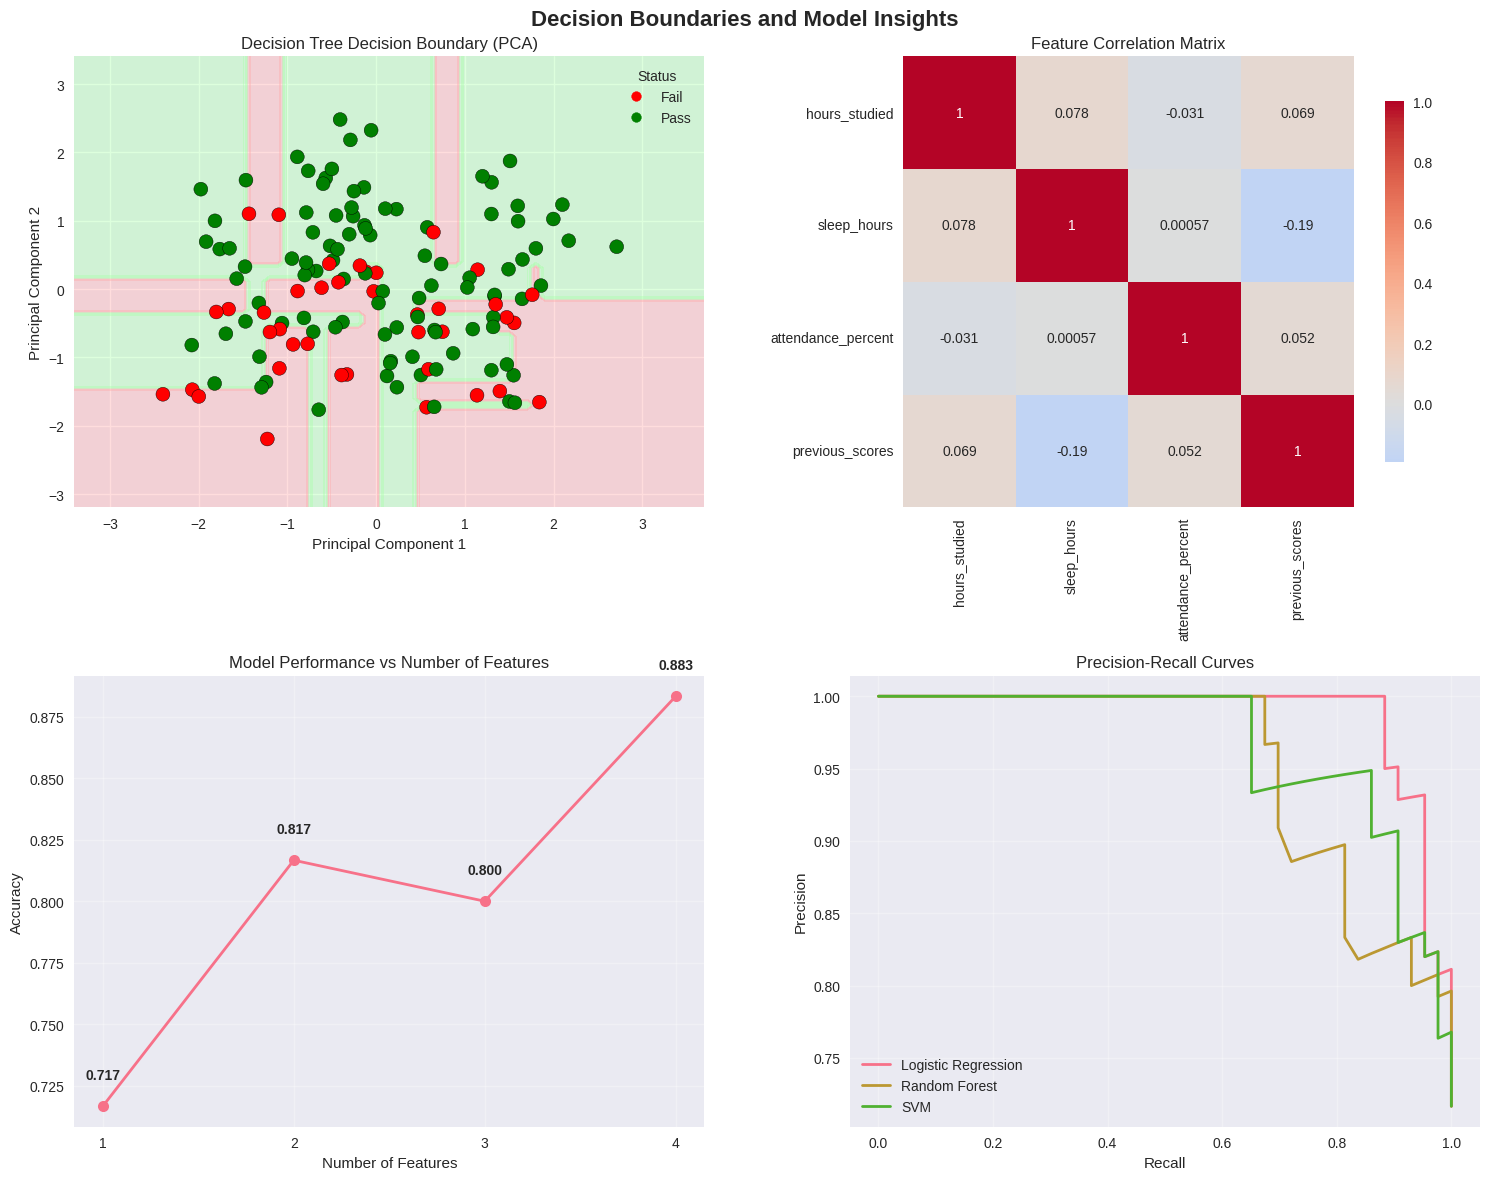

In [22]:
# Since we have multiple features, we'll visualize 2 most important features
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Use PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Train a model on PCA-transformed data
dt_pca = DecisionTreeClassifier(random_state=42)
dt_pca.fit(X_pca, y_train)

# Create mesh grid for decision boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Plot decision boundary
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Decision Boundaries and Model Insights', fontsize=16, fontweight='bold')

# Decision Boundary
Z = dt_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axes[0, 0].contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['#FFAAAA', '#AAFFAA']))
scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, 
                            cmap=ListedColormap(['red', 'green']), 
                            s=100, edgecolor='black')
axes[0, 0].set_title('Decision Tree Decision Boundary (PCA)')
axes[0, 0].set_xlabel('Principal Component 1')
axes[0, 0].set_ylabel('Principal Component 2')
axes[0, 0].legend(handles=scatter.legend_elements()[0], 
                 labels=['Fail', 'Pass'], title="Status")

# Feature Correlation Heatmap
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, ax=axes[0, 1], cbar_kws={"shrink": .8})
axes[0, 1].set_title('Feature Correlation Matrix')

# Model Performance by Feature Set
feature_combinations = [
    ['hours_studied'],
    ['hours_studied', 'sleep_hours'],
    ['hours_studied', 'sleep_hours', 'attendance_percent'],
    ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']
]

feature_performance = []
for features in feature_combinations:
    X_subset = X[features]
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        X_subset, y_encoded, test_size=0.3, random_state=42)
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_sub, y_train_sub)
    accuracy = accuracy_score(y_test_sub, model.predict(X_test_sub))
    feature_performance.append(accuracy)

axes[1, 0].plot(range(1, len(feature_combinations) + 1), feature_performance, 
               marker='o', linewidth=2, markersize=8)
axes[1, 0].set_title('Model Performance vs Number of Features')
axes[1, 0].set_xlabel('Number of Features')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_xticks(range(1, len(feature_combinations) + 1))
axes[1, 0].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(feature_performance):
    axes[1, 0].text(i + 1, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Precision-Recall Curve
for name in ['Logistic Regression', 'Random Forest', 'SVM']:
    if name in probabilities:
        precision, recall, _ = precision_recall_curve(y_test, probabilities[name])
        axes[1, 1].plot(recall, precision, label=f'{name}', linewidth=2)

axes[1, 1].set_title('Precision-Recall Curves')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#  Hyperparameter Tuning and Optimization

In [23]:
# Hyperparameter tuning for the best model
print("="*70)
print("HYPERPARAMETER TUNING FOR RANDOM FOREST")
print("="*70)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform grid search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
print(f"Best estimator: {grid_search.best_estimator_}")

# Train with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Test accuracy with tuned model: {best_accuracy:.3f}")

HYPERPARAMETER TUNING FOR RANDOM FOREST
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.829
Best estimator: RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=42)
Test accuracy with tuned model: 0.767


# Prediction Probabilities and Confidence

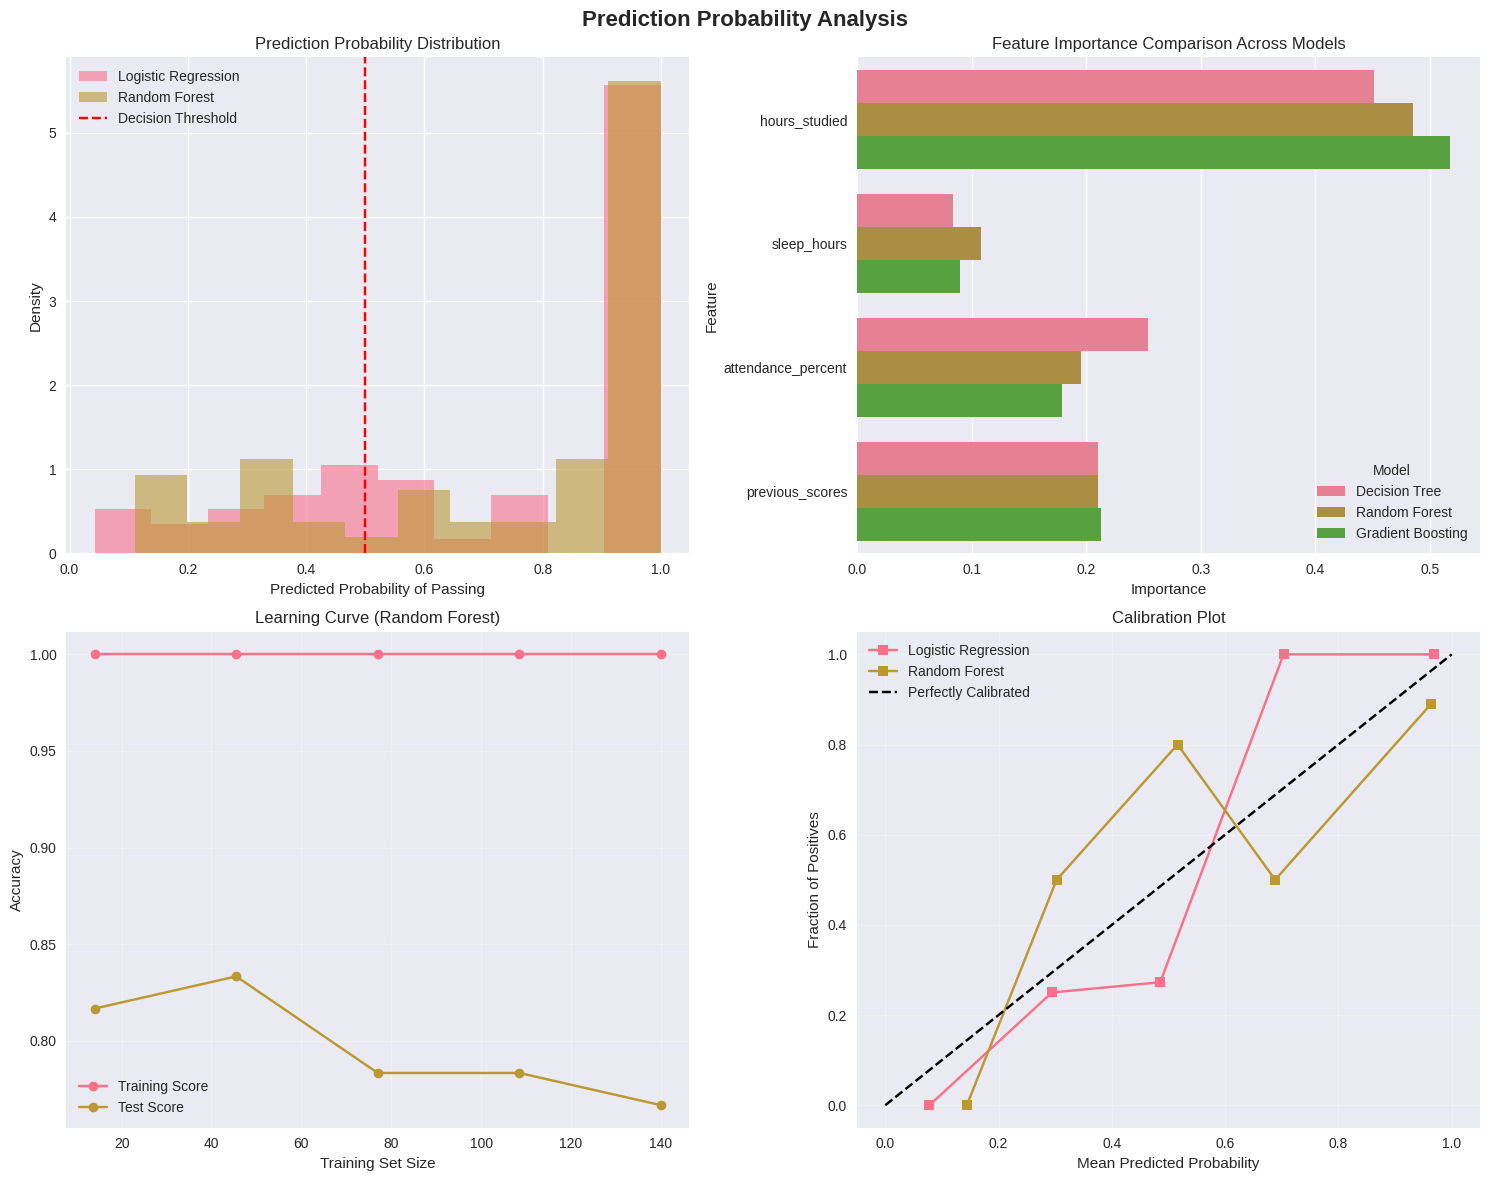

In [24]:
# Analyze prediction probabilities
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Prediction Probability Analysis', fontsize=16, fontweight='bold')

# 1. Probability Distribution
for name in ['Logistic Regression', 'Random Forest']:
    if name in probabilities:
        axes[0, 0].hist(probabilities[name], bins=10, alpha=0.6, label=name, density=True)
axes[0, 0].set_title('Prediction Probability Distribution')
axes[0, 0].set_xlabel('Predicted Probability of Passing')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
axes[0, 0].legend()

# 2. Feature Importance Comparison
models_for_importance = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
importance_data = []

for model_name in models_for_importance:
    if hasattr(results[model_name]['model'], 'feature_importances_'):
        importances = results[model_name]['model'].feature_importances_
        for feature, importance in zip(feature_names, importances):
            importance_data.append({'Model': model_name, 'Feature': feature, 'Importance': importance})

importance_df = pd.DataFrame(importance_data)
sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Model', ax=axes[0, 1])
axes[0, 1].set_title('Feature Importance Comparison Across Models')

# 3. Learning Curve (simulated due to small dataset)
train_sizes = np.linspace(0.1, 1.0, 5)
train_scores = []
test_scores = []

for size in train_sizes:
    n_samples = int(size * len(X_train))
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_subset, y_subset)
    
    train_score = accuracy_score(y_subset, model.predict(X_subset))
    test_score = accuracy_score(y_test, model.predict(X_test))
    
    train_scores.append(train_score)
    test_scores.append(test_score)

axes[1, 0].plot(train_sizes * len(X_train), train_scores, 'o-', label='Training Score')
axes[1, 0].plot(train_sizes * len(X_train), test_scores, 'o-', label='Test Score')
axes[1, 0].set_title('Learning Curve (Random Forest)')
axes[1, 0].set_xlabel('Training Set Size')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Model Calibration
from sklearn.calibration import calibration_curve

for name in ['Logistic Regression', 'Random Forest']:
    if name in probabilities:
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, probabilities[name], n_bins=5, strategy='uniform')
        axes[1, 1].plot(mean_predicted_value, fraction_of_positives, 's-', label=name)

axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[1, 1].set_title('Calibration Plot')
axes[1, 1].set_xlabel('Mean Predicted Probability')
axes[1, 1].set_ylabel('Fraction of Positives')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final Model Deployment and Insights

In [25]:
# Final model selection and insights
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

print("="*70)
print("FINAL MODEL SELECTION AND INSIGHTS")
print("="*70)
print(f"Best Performing Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.3f}")
print(f"Cross-Validation Score: {results[best_model_name]['cv_mean']:.3f} ± {results[best_model_name]['cv_std']:.3f}")

# Feature importance for the best model
if hasattr(best_model, 'feature_importances_'):
    print("\nFeature Importance:")
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    print(feature_importance_df)

# Make predictions on the entire dataset
final_predictions = best_model.predict(X)
final_probabilities = best_model.predict_proba(X)[:, 1] if hasattr(best_model, 'predict_proba') else None

# Create final results dataframe
final_results = df.copy()
final_results['predicted_status'] = le.inverse_transform(final_predictions)
if final_probabilities is not None:
    final_results['pass_probability'] = final_probabilities
final_results['prediction_correct'] = final_results['status'] == final_results['predicted_status']

print("\nFinal Predictions:")
print(final_results[['student_id', 'hours_studied', 'exam_score', 'status', 
                    'predicted_status', 'pass_probability', 'prediction_correct']])

# Calculate overall performance
overall_accuracy = (final_results['prediction_correct']).mean()
print(f"\nOverall Model Accuracy on Complete Data: {overall_accuracy:.3f}")


FINAL MODEL SELECTION AND INSIGHTS
Best Performing Model: Logistic Regression
Test Accuracy: 0.883
Cross-Validation Score: 0.850 ± 0.070

Final Predictions:
    student_id  hours_studied  exam_score status predicted_status  \
0         S001            8.0        30.2   Pass             Pass   
1         S002            1.3        25.0   Fail             Pass   
2         S003            4.0        35.8   Pass             Pass   
3         S004            3.5        34.0   Pass             Pass   
4         S005            9.1        40.3   Pass             Pass   
..         ...            ...         ...    ...              ...   
195       S196           10.5        42.7   Pass             Pass   
196       S197            7.1        40.4   Pass             Pass   
197       S198            1.6        28.2   Fail             Pass   
198       S199           12.0        42.0   Pass             Pass   
199       S200           10.2        37.8   Pass             Pass   

     pass_prob